In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import sys
from matplotlib.patches import Rectangle
from netCDF4 import Dataset

In [ ]:
class Data_processing:
    def __init__(self,url):
        # 데이터를 가져오기 위한 url 저장
        self.url = url

        # 데이터셋 저장
        self.result = None
        self.pre_data = None

        # 시작, 끝 년도/월별 idx와 값 초기화
        self.start_y_idx = None
        self.end_y_idx = None
        self.end_month = None
        self.start_month = None

    def y_getter(self, variable):
        if variable == 'start':
            return self.start_y_idx
        else:
            return self.end_y_idx
        return 'input param like "start" or "end"'

    def m_getter(self, variable):
        if variable == 'start':
            return self.start_month
        else:
            return self.end_month
        return 'input param like "start" or "end"'

    # 데이터 전처리
    def get_data(self, variable, date=None):   # date는 년도, 월 순으로 기입 (예시 : 195001, 195001-198001)
        f = Dataset(self.url)
        f.set_auto_mask(False)
    
        result = f.variables[variable][:]
        result = result.reshape(-1,12,73,144)

    # 결측치 처리
        result = np.where(result==-9.99e+08, np.nan, result)

        if date is not None:
            # date가 범위인 경우 ('YYYY-YYYY') 처리 년도를 처리해줄 때 사용
            if '-' in date:
                start_date, end_date = date.split('-')
                start_year, self.start_month = int(start_date[:4]), int(start_date[4:])
                end_year, self.end_month = int(end_date[:4]), int(end_date[4:])

                # 날짜 범위에 맞는 인덱스를 찾아서 데이터 슬라이싱
                self.start_y_idx, self.end_y_idx = start_year - 1950, end_year - 1950  # 1950년을 기준으로 인덱스 계산

                # 날짜 범위에 맞게 데이터를 슬라이싱
                pre_data = result[self.start_y_idx:self.end_y_idx, :, :, :]
            
            else:
            # 단일 날짜에 대한 처리
                year, month = int(date[:4])-1950, 12 - int(date[4:])
                pre_data = result[year,month, :, :] # 해당 월에 해당하는 데이터 추출
            self.result, self.pre_data = result, pre_data 
        return result, pre_data

    # djf 월평균 데이터 출력
    def season_process(self, *seasons, anom_list=None):  # 입력: *seasons = ('djf1', 'djf2', 'mam', 'jja', 'son')
        data = self.pre_data if anom_list is None else anom_list
        print(data.shape)
        list_temp = []

        # 시즌별 데이터 처리 함수
        def process(season):
            """ 시즌에 맞는 처리 """
            if season == 'djf1':
                nino = np.concatenate([data[:-1], data[1:]], axis=1)
                return np.mean(nino[:, 11:14], axis=1)
            elif season == 'djf2':
                data_add = self.result[self.end_y_idx+1,:,:,:]
                
                # 만약 아노말리 리스트를 받은게 아니라면 실행 (데이터 맞추기기)
                if not np.array_equal(data, self.pre_data):
                    # 아노말리 구하기
                    climatology = np.nanmean(data_add, axis=0) 
                    anom = data_add - climatology 
                data_added = np.concatenate([data, anom[np.newaxis,:,:,:]], axis=0)
                data_added = data_added[1:,:,:,:]
                nino = np.concatenate([data_added[:-1], data_added[1:]], axis=1)
                return np.mean(nino[:, 11:14], axis=1)
            elif season == 'mam':       # [1:]
                print('functionnp.mean(data[:, 2:5], axis=1)', np.mean(data[:, 2:5], axis=1).shape)
                return np.mean(data[1:, 2:5], axis=1)  # MAM 처리
            elif season == 'jja':
                return np.mean(data[1:, 5:8], axis=1)  # JJA 처리
            elif season == 'son':
                return np.mean(data[1:, 8:11], axis=1)  # SON 처리
            return None

        # 매핑된 시즌들을 처리
        for season in seasons:
            season_data = process(season)
            # print(season_data, season)
            if season_data is not None:
                list_temp.append(season_data)

        return list_temp


    # nino 3.4 지역평균 데이터 출력
    def region_mean(self, data_list=None, nino34=False):
        # 위도 가중치 적용 (cos(lat))
        lat = np.arange(-90, 92.5, 2.5)  # 위도 배열 생성
        lat = np.cos(np.radians(lat))  # 위도에 따른 가중치 계산
        lat = np.full_like(data_list, lat[np.newaxis, :, np.newaxis])  # (29, 73, 144) 형태로 확장
        lat = np.where(np.isnan(data_list), np.nan, lat)  # 결측값 반영
        
        if nino34 is True:
            pick_dat = data_list[:,34:39, 76:97]
            pick_lat = lat[:,34:39, 76:97]
            idx = np.nansum(pick_dat * pick_lat, axis=(1, 2)) / np.nansum(lat, axis=(1, 2))  # (29,)
        # 위도 가중 평균 계산
        else:
            idx = np.nansum(data_list * lat, axis=(1, 2)) / np.nansum(lat, axis=(1, 2))  # (29,)

        return idx
        

/tmp/ipykernel_3386041/4042960927.py:14: RuntimeWarning: Mean of empty slice
  sst_climatology_jan = np.nanmean(sst[:,0,:,:], axis=0)


(70, 73, 144)
(73, 144)


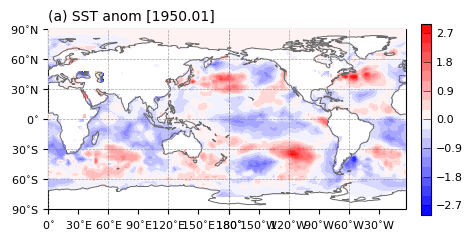

In [ ]:
# 클래스를 만들어 쓰기 전 ~~

o_path = '/home/inhye_yoo/edu/'
o_name = 'ERA.sst.1950_2019.nc'

f = Dataset(o_path+o_name)
f.set_auto_mask(False)
    
sst = f.variables['p'][:]
sst = sst.reshape(-1,12,73,144)

# 결측치 처리
sst = np.where(sst==-9.99e+08, np.nan, sst)
sst_jan = sst[:,0,:,:]
#1950년 ~ 2019년 1월 평균 SST(기후평균, 73, 144)
sst_climatology_jan = np.nanmean(sst[:,0,:,:], axis=0)

# sst의 아노말리 구하기
sst_anom = sst_jan - sst_climatology_jan
print(sst_anom.shape)

sst_anom = sst_anom[1,:,:]
print(sst_anom.shape)

# plot
cmap = plt.colormaps['bwr']    # blue-white-red 색상 맵맵
clevs = np.arange(-3.0, 3.001, 0.3) # clevs는 등치선(contour level) 설정정
vm = 3.0
vn = -3.0

# make grid/ 위도- 경도 좌표를 생성하고, 지도 좌표계를 설정하며, 격자선을 추가하는 부분분
x, y = np.meshgrid(np.arange(0, 360.0, 2.5), np.arange(-90.0, 92.5, 2.5)) # 경도(x)와 위도(y) 격자점을 생성성
fig = plt.figure(figsize = (11, 8.5))                                     # 지도 객체 생성
ax = fig.add_subplot(2, 2, 1, projection = ccrs.PlateCarree(central_longitude=180.0)) # 2X2 서브플롯(grid) 중 첫번째(1번) 플롯을 생성
grd = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                        linewidth=0.5, linestyle='dashed', color='gray', alpha=0.7, zorder=7)

# 경도, 위도 눈금을 30도 간격으로 생성
lon_ticks = np.arange(-180, 181, 30)
lat_ticks = np.arange(-90, 91, 30)

# 위도 눈금 위치 설정
grd.ylocator = mticker.FixedLocator(lat_ticks)
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

# 경도 및 위도 눈금 포맷 설정정
lon_fmt = LongitudeFormatter(number_format='.0f', degree_symbol=r'$^{\circ}$')
lat_fmt = LatitudeFormatter(number_format='.0f', degree_symbol=r'$^{\circ}$')
ax.xaxis.set_major_formatter(lon_fmt)
ax.yaxis.set_major_formatter(lat_fmt)
plt.setp(ax.get_xticklabels(), fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)

# 해안선따라 선긋기기
ax.coastlines(linewidth=0.7, color='dimgray', zorder=7)
plt.title('(a) SST anom [1950.01]', loc='left', fontsize=10)

# 첫번째 아노말리 그래프
cax = plt.contourf(x, y, sst_anom , levels=clevs, cmap=cmap, transform=ccrs.PlateCarree(), zorder=4)

# 컬러바의 위치와 크기 설정
cbar = plt.colorbar(cax, orientation='vertical', fraction=0.025, pad=0.04)
cbar.ax.tick_params(labelsize=8, direction='in', length=6, width=0.4, color='black', zorder=6)

plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, hspace=0.1, wspace=0.3)
plt.show()
plt.savefig(o_path+o_name+'.png', dpi=300)
plt.close()

(30, 12, 73, 144)
(29, 73, 144)


/tmp/ipykernel_3386041/4063599880.py:11: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(sst, axis=0)  # 월별 평균 (12, 73, 144)


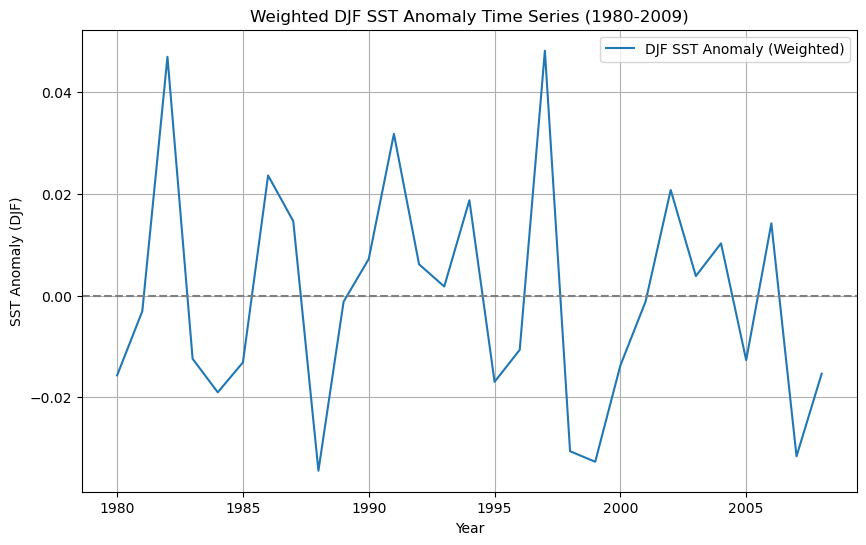

In [199]:
# 데이터 로드
p = Data_processing(o_path+o_name)
# f = Dataset(o_path + o_name)
# f.set_auto_mask(False)

# 변수 추출
_, sst = p.get_data('p', '198001-201012')
print(sst.shape)

# 기후 기준값 (climatology) 계산 후 아노말리 추출
climatology = np.nanmean(sst, axis=0)  # 월별 평균 (12, 73, 144)
anom = sst - climatology  # 아노말리 계산

# DJF 데이터 추출
nino = np.append(anom[:-1], anom[1:], axis=1)  # 한 해의 12월 + 다음 해의 1,2월
djf = np.mean(nino[:, 11:14], axis=1)  # 12, 1, 2월 평균

print(djf.shape)

# # 위도 가중 평균 계산
idx = p.region_mean(data_list=djf, nino34=True)

# 연도 설정 (1980-2009)
years = np.arange(1980, 2009)

# 시계열 플롯 만들기
plt.figure(figsize=(10, 6))
plt.plot(years, idx, linestyle='-', label="DJF SST Anomaly (Weighted)")
plt.axhline(0, color='gray', linestyle='--')  # 0 기준선 추가
plt.xlabel('Year')
plt.ylabel('SST Anomaly (DJF)')
plt.title('Weighted DJF SST Anomaly Time Series (1980-2009)')
plt.grid(True)
plt.legend()
plt.show()


In [194]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


(30, 12, 73, 144)
functionnp.mean(data[:, 2:5], axis=1) (30, 73, 144)


/tmp/ipykernel_3386041/258704588.py:79: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(data_add, axis=0)


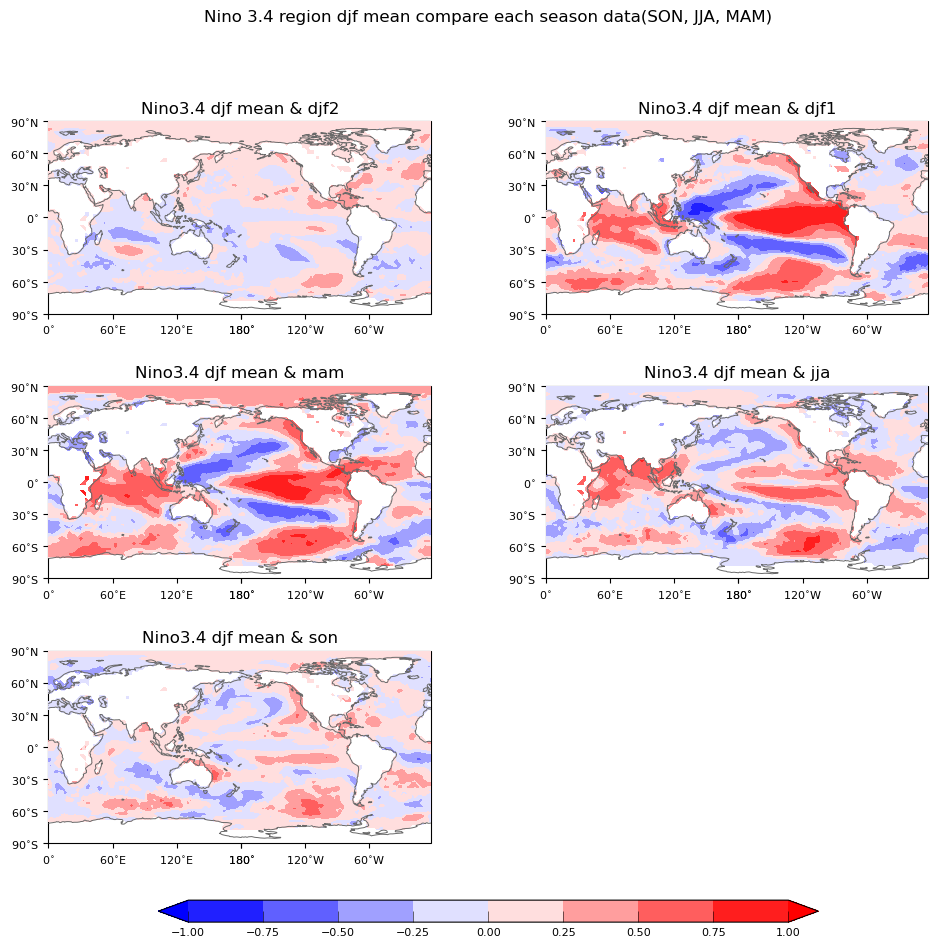

In [188]:
djf_mean = idx
# 계절별 데이터 슬라이싱

season = ['djf2', 'djf1', 'mam', 'jja', 'son']

# 계절별 데이터 뽑기기
djf2, djf, mam, jja, son = p.season_process(*season, anom_list=anom) 
# print(djf2.shape, mam.shape, jja.shape, son.shape)

def corr(x,y):
    x = x[:, np.newaxis, np.newaxis]  # 차원 확장
    # y = y[:, :, :]  # y의 첫 번째 차원 크기를 29로 맞춤
    xy = np.mean(x*y, axis=0)
    xx = np.mean(x**2, axis=0)
    yy = np.mean(y**2, axis=0)
    cor = xy/np.sqrt(xx*yy)
    return cor

# 상관계수 배열을 하나로 합침
correlation_matrix = [corr(djf_mean, season) for season in [djf2, djf, mam, jja, son]]

# plot
# cmap = plt.colormaps['bwr']             #Blue-white-red 색상맵맵
clevs = np.arange(-1.0, 1.001, 0.25)     # clevs는 등치선(contour level)
vm = 1
vn = -1

nrows = 3
ncols = 2

# make grid 위도-경도 좌표를 생성하고, 지도 좌표계를 설정하며, 격자선을 추가하는 부분
x, y = np.meshgrid(np.arange(0,360.0, 2.5), np.arange(-90.0, 92.5, 2.5))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(11,11))

title = [f'Nino3.4 djf mean & {title}' for title in season]
# 경도, 위도 눈금을 30도 간격으로 생성
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)

# 위도 눈금 위치 설정
grd.ylocator = mticker.FixedLocator(lat_ticks)

axs=axs.flatten()

for i, data in enumerate(correlation_matrix):
    # data = correlation_matrix[i][:,:,:]
    # print(data)
    # data, lons = add_cyclic_point(correlation_matrix[i],coord=data['lon'])
    cs = axs[i].contourf(x, y, data , levels=clevs, cmap='bwr', 
                        transform=ccrs.PlateCarree(), zorder=4, extend='both')
    axs[i].set_title(title[i])

    #해안선 따라 선긋기
    axs[i].coastlines(linewidth=0.7, color='dimgray', zorder=7)

    # ㅣlon
    axs[i].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    lon_fmt = LongitudeFormatter(number_format='.0f', degree_symbol=r'$^{\circ}$')
    axs[i].xaxis.set_major_formatter(lon_fmt)
    axs[i].tick_params(axis='x', labelsize=8)

    # lat
    axs[i].set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lat_fmt = LatitudeFormatter(number_format = '.0f', degree_symbol=r'$^{\circ}$')
    axs[i].yaxis.set_major_formatter(lat_fmt)
    axs[i].tick_params(axis='y', labelsize=8)

    # axs[i].setp(ax.get_xticklabels(), fontsize=8)
    # axs[i].setp(ax.get_yticklabels(), fontsize=8)

fig.delaxes(axs[5])
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, hspace=0.1, wspace=0.3)
# cax2 = plt.contourf(x, y, correlation_matrix[2] , levels=clevs, cmap=cmap, transform=ccrs.PlateCarree(), zorder=4)

# 컬러바의 위치와 크기 설정
cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])

cbar =fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8, direction='in', length=8, width=0.4, color='black', zorder=6)

plt.suptitle('Nino 3.4 region djf mean compare each season data(SON, JJA, MAM)')
plt.show()
plt.savefig(o_path+o_name+'.png', dpi=300)
plt.close()

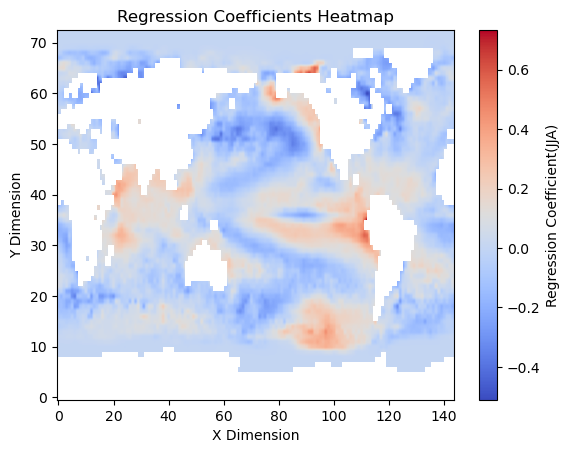

In [189]:
def reg(x, y):
    x = x[:, np.newaxis, np.newaxis]  # 차원 확장
    y = y[:, :, :]  # y의 첫 번째 차원 크기를 29로 맞춤
    xy = np.mean(x*y, axis=0)
    xx=np.mean(x**2, axis=0)

    reg = xy/xx
    return reg

d_d2_reg = reg(djf_mean, djf2)
d_m_reg = reg(djf_mean, mam)
d_j_reg = reg(djf_mean, jja)
d_s_reg = reg(djf_mean, son)

# 회귀 계수를 heatmap 형태로 시각화하고 이미지를 반환
img = plt.imshow(d_j_reg, cmap='coolwarm', aspect='auto')

# y축 반전
plt.gca().invert_yaxis()

# colorbar에 이미지를 전달
plt.colorbar(img, label='Regression Coefficient(JJA)')
plt.title('Regression Coefficients Heatmap')
plt.xlabel('X Dimension')
plt.ylabel('Y Dimension')
plt.show()